In [1]:
!pip install tensorflow keras Keras-Preprocessing keras.preprocessing.image 

ERROR: Could not find a version that satisfies the requirement keras.preprocessing.image (from versions: none)
ERROR: No matching distribution found for keras.preprocessing.image


In [4]:
!pip install keras_preprocessing

  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl.metadata (1.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00


In [2]:
!pip install tensorflow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 3.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.5 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is n

In [5]:
import numpy as np
import pandas as pd 
import os
import cv2 as cv
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.layers import add, Dense, Dropout, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
from keras import backend as K
import tensorflow as tf
from keras_preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')

In [6]:
train_high = "/kaggle/input/lol-dataset/lol_dataset/our485/high"
train_low = "/kaggle/input/lol-dataset/lol_dataset/our485/low"

test_high = "/kaggle/input/lol-dataset/lol_dataset/eval15/high"
test_low = "/kaggle/input/lol-dataset/lol_dataset/eval15/low"

SIZE = 256

In [7]:
def load_images(path):
    x = []
    for imageDir in os.listdir(path):
        img_path = os.path.join(path, imageDir)
        img = cv.imread(img_path,1)
        if img is None:
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (SIZE, SIZE)) 
        img = img.astype('float32') / 255.0
        x.append(img)
        
        img1 = cv.flip(img,1)
        x.append(img_to_array(img1))
        
        img2 = cv.flip(img,-1)
        x.append(img_to_array(img2))
        
        img3 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
        x.append(img_to_array(img3))
        
        img4 = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
        x.append(img_to_array(img4))
    
    return x

In [8]:
x_train = load_images(train_low)
y_train = load_images(train_high)

x_test = load_images(test_low)
y_test = load_images(test_high)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))


x_train = np.reshape(x_train, (len(x_train), SIZE, SIZE, 3))
y_train = np.reshape(y_train, (len(y_train), SIZE, SIZE, 3))

x_test = np.reshape(x_test, (len(x_test), SIZE, SIZE, 3))
y_test = np.reshape(y_test, (len(y_test), SIZE, SIZE, 3))

2425
2425
75
75


In [9]:
def plot_images(image, ground_truth):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 10)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.imshow(ground_truth)
   
    plt.show()

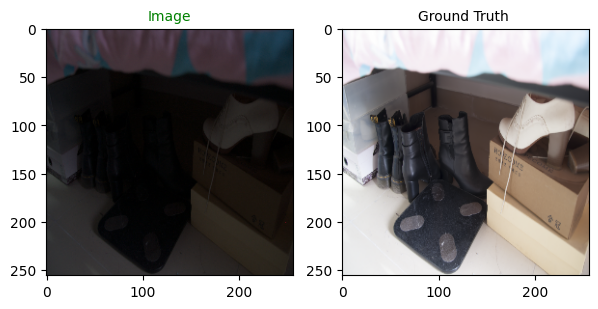

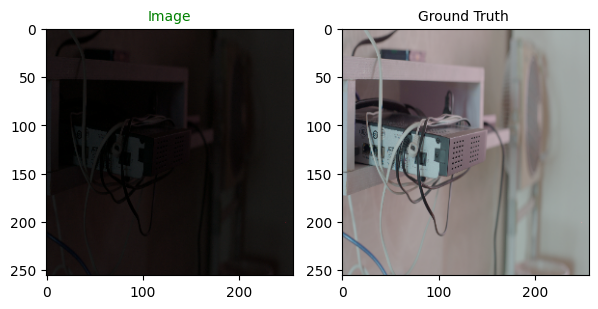

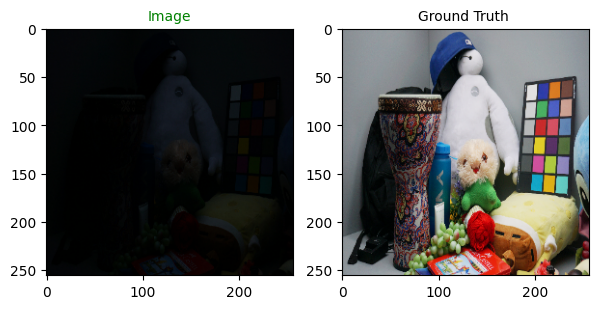

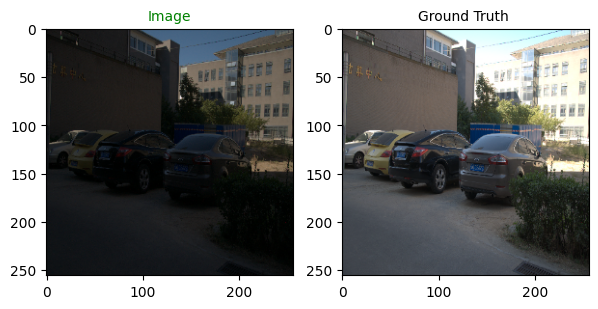

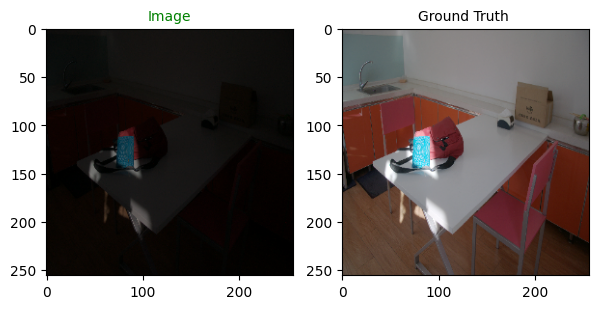

In [10]:
for i in range(0,25,5):
    plot_images(x_train[i],y_train[i])

In [11]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

In [12]:
def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout: 
        upsample.add(Dropout(0.1))
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [13]:
def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)

    u1 = up(512,(3,3),True)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),True)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),True)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),True)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),True)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [14]:
model = model()
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,584 │ input_layer[0][0] │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    147,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    296,192 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  1,182,208 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  2,361,856 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │  2,359,808 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ sequential_5[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 32, 32,    │  2,359,552 │ concatenate[0][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ sequential_6[0][… │
│ (Concatenate)       │ 512)              │            │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64, 64,    │    589,952 │ concatenate_1[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 256)              │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 128, 128,  │    295,040 │ concatenate_2[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 256)              │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 256, 256,  │      6,915 │ concatenate_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256, 256,  │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 6)                │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 256, 256,  │         75 │ concatenate_4[0]

 Total params: 9,602,766 (36.63 MB)

 Trainable params: 9,600,206 (36.62 MB)

 Non-trainable params: 2,560 (10.00 KB)

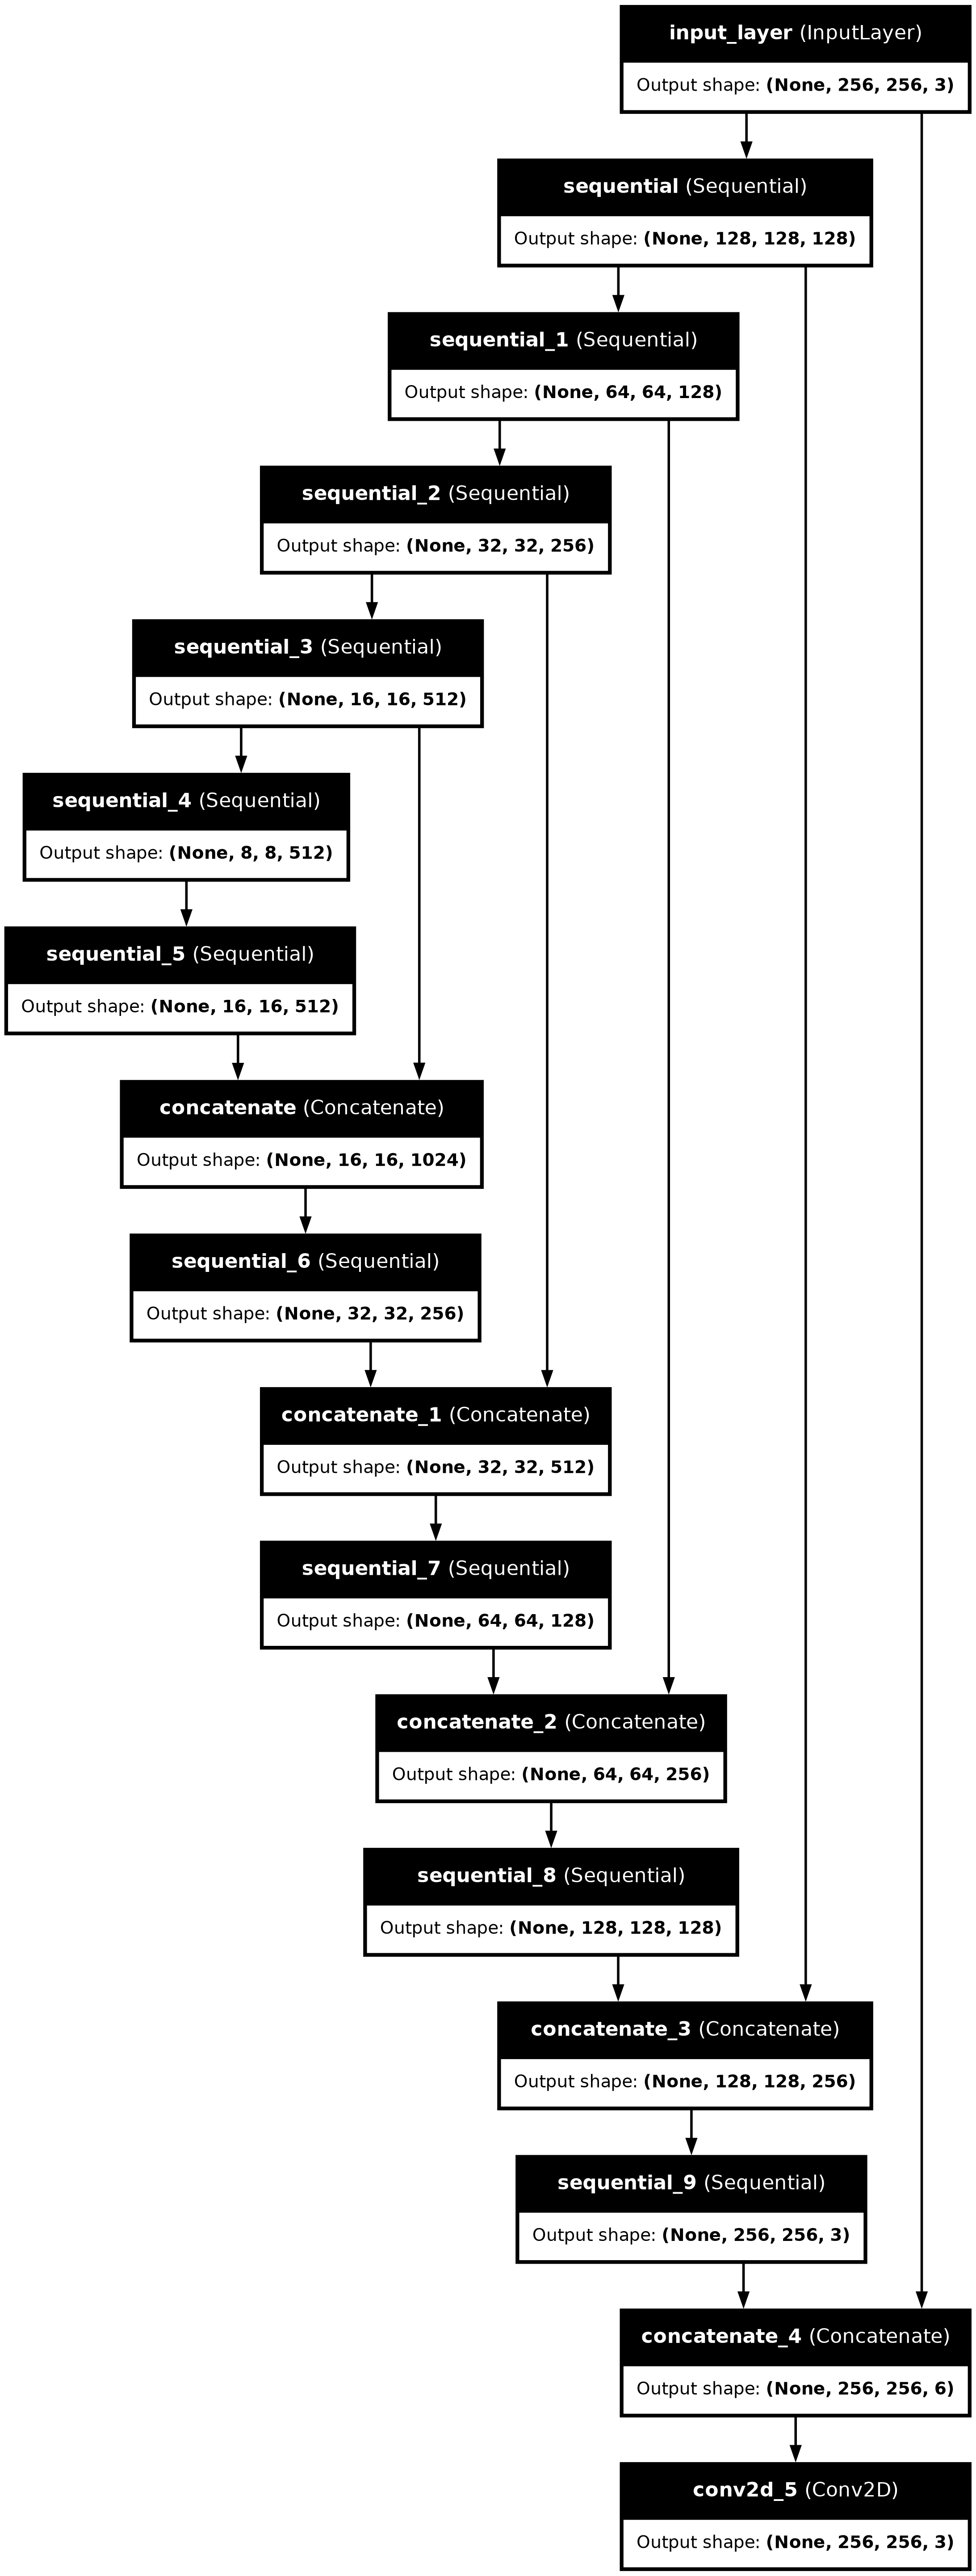

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [16]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(x_train, y_train, epochs = 100 ,batch_size = 50, verbose = 1, steps_per_epoch=60, shuffle=True)

Epoch 1/100


I0000 00:00:1712947915.983140     106 service.cc:145] XLA service 0x7a741420ce40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712947915.983211     106 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1712947937.415621     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 52s 447ms/step - acc: 0.3104 - loss: 0.3036
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.3911 - loss: 0.1741
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.4437 - loss: 0.1459
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.4673 - loss: 0.1364
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - acc: 0.4701 - loss: 0.1322
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.4923 - loss: 0.1268
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.5042 - loss: 0.1230
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.5221 - loss: 0.1189
Epoch 9/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.5317 - loss: 0.1174
Epoch 10/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - acc: 0.5538 - loss: 0.1164
Epoch 11/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - acc: 0.5442 - loss: 0.1153
Epoch 12/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - acc: 0.5552 - loss: 0.1124
Epoch 13/100


In [22]:
def plot_images(image,ground_truth,predicted):
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.title('Original Image', color = 'green', fontsize = 10)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.imshow(ground_truth)
    plt.subplot(1,3,3)
    plt.title('Enhanced ', color = 'Red', fontsize = 10)
    plt.imshow(predicted)
   
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


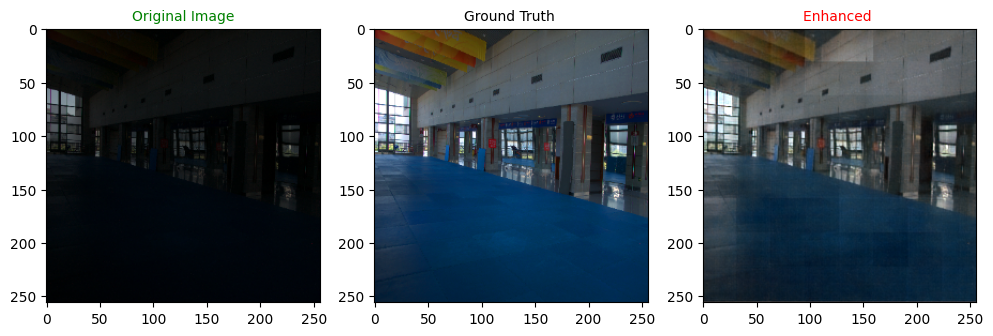

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


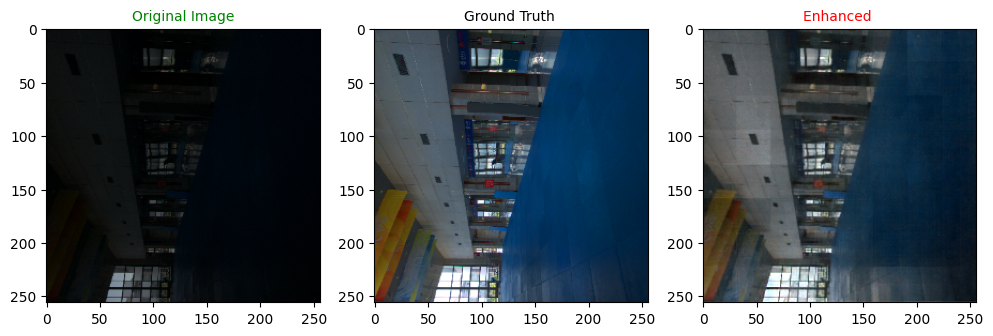

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


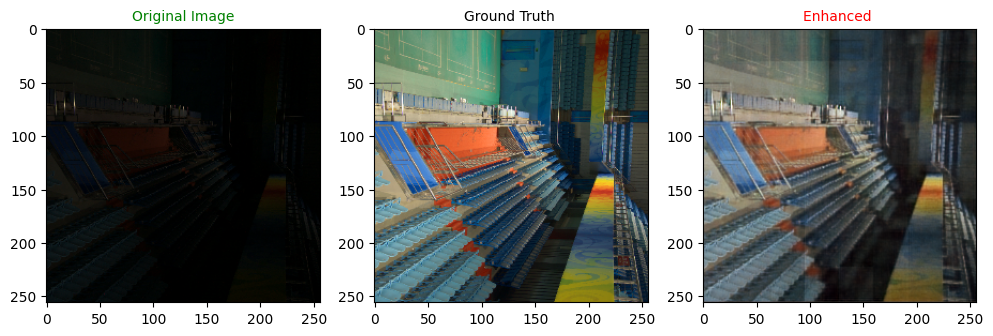

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


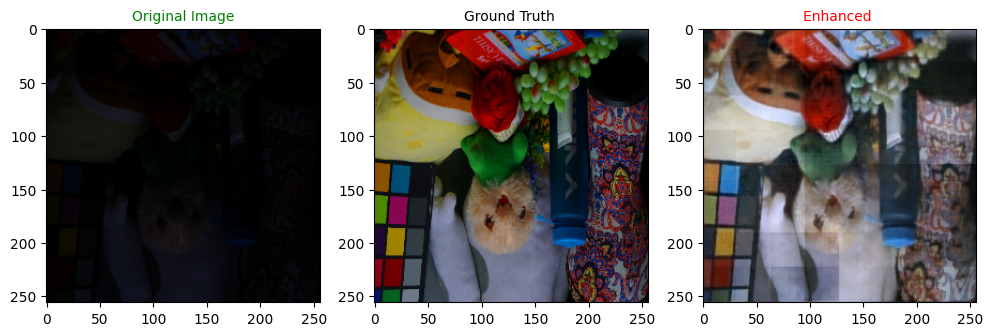

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


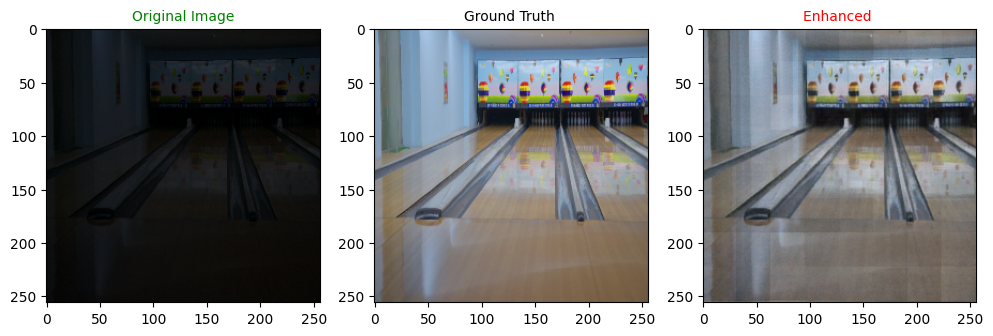

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


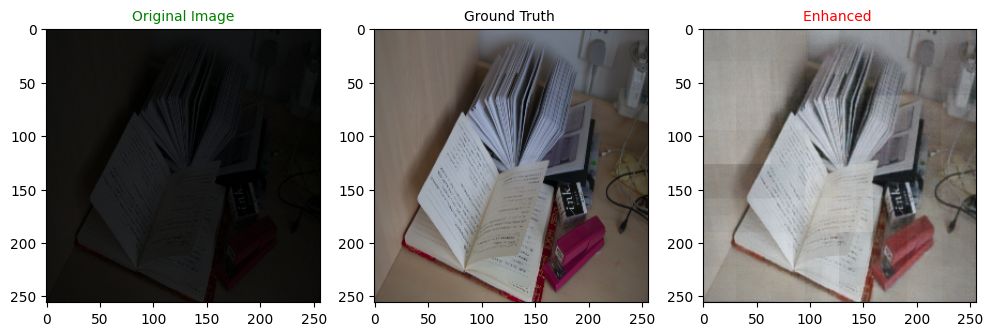

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


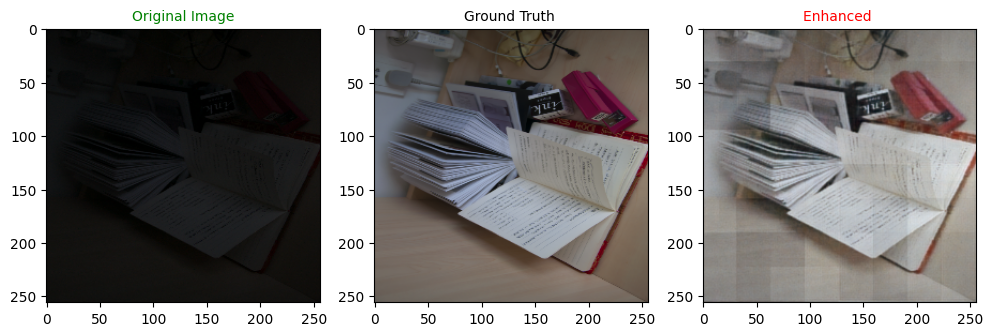

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


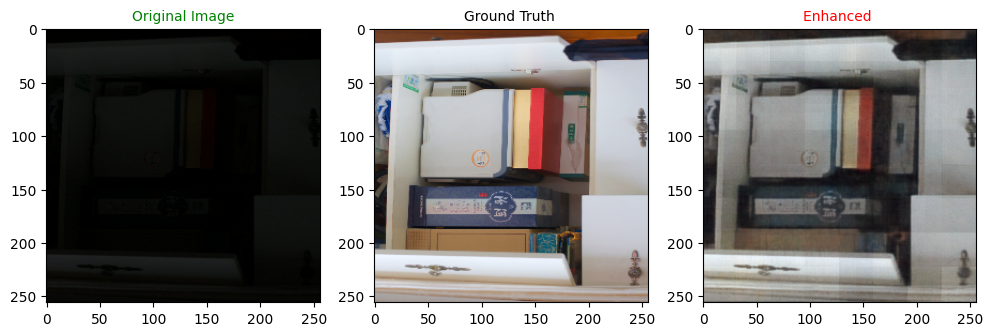

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


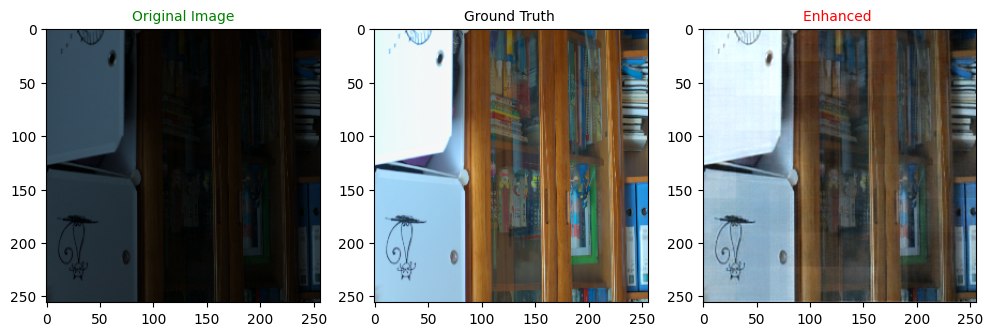

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


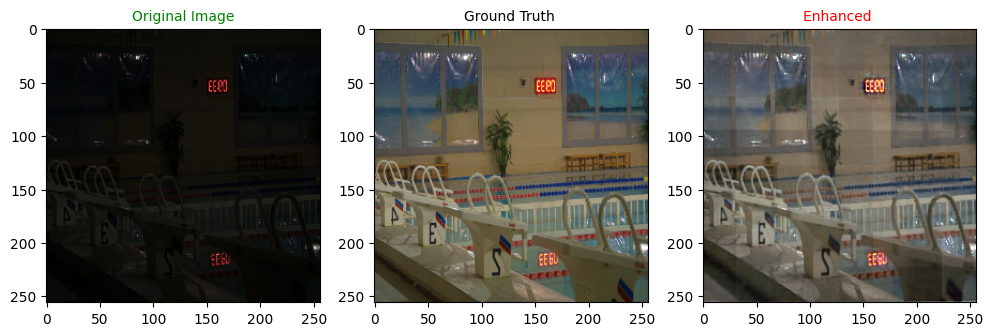

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


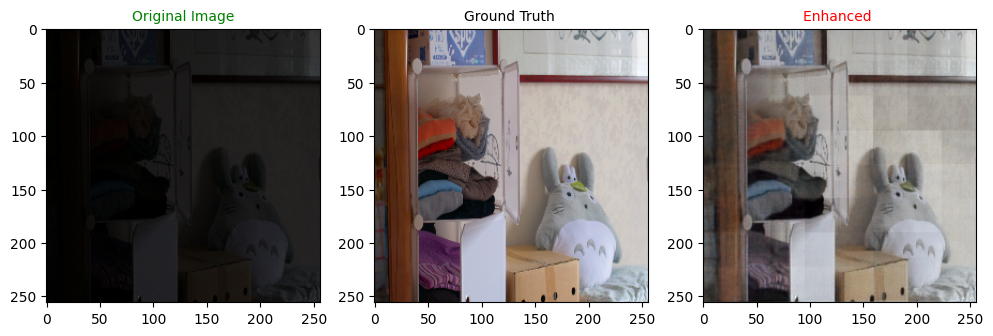

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


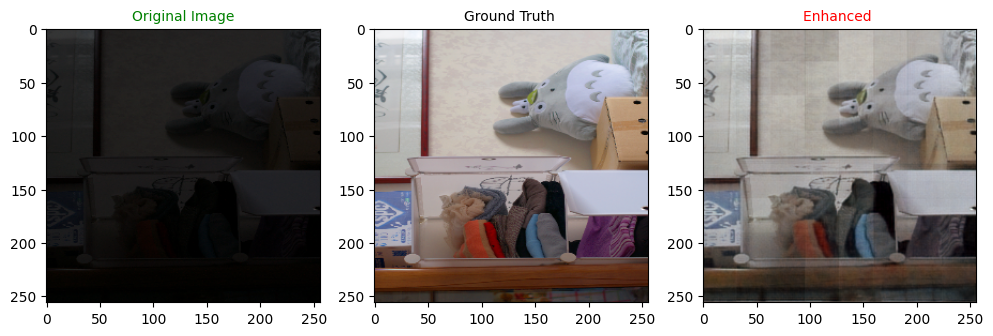

In [23]:
for i in range(0,45,4):
    predicted = np.clip(model.predict(x_test[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(x_test[i],y_test[i],predicted)

In [19]:
!pip install scikit-image

In [21]:
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_model_psnr(model, x_data, y_true, num_samples=10):
    """Evaluate the model using PSNR only."""
    psnr_values = []
    indices = np.random.choice(range(len(x_data)), num_samples, replace=False)

    for idx in indices:
        y_pred = model.predict(x_data[idx].reshape(1, SIZE, SIZE, 3))
        y_pred = np.clip(y_pred, 0, 1)  
        gt_image = y_true[idx]
        predicted_image = y_pred[0]

        # Calculate PSNR
        psnr_val = psnr(gt_image, predicted_image, data_range=1)
        psnr_values.append(psnr_val)

    # Compute average
    avg_psnr = np.mean(psnr_values)
    return avg_psnr

# Evaluation function after model training
avg_psnr = evaluate_model_psnr(model, x_test, y_test, num_samples=30)
print(f"Average PSNR: {avg_psnr:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━